In [1]:
#!git clone https://github.com/zhestyatsky/mipt-opt-project.git
#import sys
#sys.path.append('/content/mipt-opt-project/src')

In [2]:
import copy
import matplotlib.pyplot as plt

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import utils
from spider_boost import spider_boost
from natasha import natasha_15, natasha_2

In [3]:
train_dataset = dsets.MNIST(root='~/.pytorch/MNIST_data/', train=True, transform=transforms.ToTensor(), download=True)
train_dataset = utils.DatasetWrapper(train_dataset)

In [4]:
class CustomModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomModel, self).__init__()
        self.conv1 = torch.nn.Linear(input_dim, 28)
        self.conv2 = torch.nn.Linear(28, output_dim)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        outputs = torch.sigmoid(self.conv2(x))
        return outputs

In [5]:
loss = torch.nn.CrossEntropyLoss().cuda()
regularizer = utils.regularizer

In [6]:
batch_size = 2048
learning_rate = 0.01
n_epochs = 100

In [7]:
gd_model = CustomModel(784, 10)
sb_model = copy.deepcopy(gd_model)
n15_model = copy.deepcopy(gd_model)
n2_model = copy.deepcopy(gd_model)

if torch.cuda.is_available():
    gd_model = gd_model.cuda()
    sb_model = sb_model.cuda()
    n15_model = n15_model.cuda()
    n2_model = n2_model.cuda()

In [8]:
%%time
gd_total_loss = utils.gradient_descent(train_dataset, batch_size, gd_model, loss, regularizer, learning_rate, n_epochs)

CPU times: user 3.31 s, sys: 140 ms, total: 3.45 s
Wall time: 1.4 s


In [9]:
%%time
sb_total_loss = spider_boost(train_dataset, batch_size, sb_model, loss, regularizer, learning_rate, n_epochs)

CPU times: user 3.97 s, sys: 154 ms, total: 4.12 s
Wall time: 1.68 s


In [10]:
%%time
n_15_total_loss = natasha_15(train_dataset, batch_size, n15_model, loss, regularizer, learning_rate, n_epochs, sigma=10)

epoch: 0


CPU times: user 8.77 s, sys: 414 ms, total: 9.19 s
Wall time: 8.89 s


In [11]:
%%time
n_2_total_loss = natasha_2(train_dataset, batch_size, n2_model, loss, regularizer, learning_rate, n_epochs)

CPU times: user 29.1 s, sys: 1.88 s, total: 31 s
Wall time: 22.1 s


[]

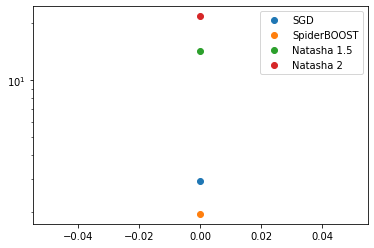

In [16]:
plt.plot(gd_total_loss, 'o', label = 'SGD')
plt.plot(sb_total_loss, 'o', label = 'SpiderBOOST')
plt.plot(n_15_total_loss, 'o', label = 'Natasha 1.5')
plt.plot(n_2_total_loss, 'o', label = 'Natasha 2')
plt.legend()
plt.semilogy()